# Corpus and references:
https://www.kaggle.com/aiswaryaramachandran/hindienglish-corpora

# Packages

In [0]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import string
import re
import matplotlib.pyplot as plt
import pickle
from string import digits

In [2]:
from keras.layers import Dense,LSTM,Embedding,RepeatVector,Input,TimeDistributed,Bidirectional
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model,Model,Sequential
from keras.utils import to_categorical
import tensorflow as tf
from keras.callbacks import TensorBoard
from tqdm import tqdm
from keras.utils import plot_model

Using TensorFlow backend.


# Read Data

In [0]:
# read dataset
data=pd.read_csv("Hindi_English_Truncated_Corpus.csv",encoding="utf-8")
data=data.dropna()
data=data[data['source']=='ted']#data.sample(frac=0.5)

In [4]:
data

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है
...,...,...,...
127595,ted,is if we want that to become our reality -,अगर हम चाहते हैं कि यह वास्तविकता बने -
127597,ted,Africa has not done bad.,अफ़्रीका ने कुछ गलती नहीं की है।
127598,ted,Thank you.,धन्यवाद |
127603,ted,and put it in our cheeks.,और अपने गालों में डाल लेते हैं।


# Preprocessing

In [0]:
def ProcessData(data):
  # drop duplicates from table
  data.drop_duplicates(inplace=True)
  # making a set of punctuations
  specialCharList = set(string.punctuation)
  
  #Removing digits
  data['english_sentence']=data['english_sentence'].str.replace('\d+', '')
  data['hindi_sentence']=data['hindi_sentence'].str.replace('\d+', '')

  # change english to lower
  data['english_sentence']=data['english_sentence'].apply(lambda x: x.lower())

  # Removing quotes from english and hindi sentences
  data['english_sentence'] = data['english_sentence'].str.replace(r"[\"\',]", '')
  data['hindi_sentence'] = data['hindi_sentence'].str.replace(r"[\"\',]", '')

  # Removing all the special characters
  data['english_sentence']=data['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in specialCharList))
  data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in specialCharList))

  # Removing extra spaces
  data['english_sentence']=data['english_sentence'].str.strip()
  data['hindi_sentence']=data['hindi_sentence'].str.strip()

  # Add start and end tokens to target sequences
  data['hindi_sentence'] = data['hindi_sentence'].apply(lambda x : 'SSSSS '+ x + ' EEEEE')
  return data

In [6]:
data=ProcessData(data)
data

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,SSSSS राजनीतिज्ञों के पास जो कार्य करना चाहिए ...
1,ted,id like to tell you about one such child,SSSSS मई आपको ऐसे ही एक बच्चे के बारे में बतान...
3,ted,what we really mean is that theyre bad at not ...,SSSSS हम ये नहीं कहना चाहते कि वो ध्यान नहीं द...
7,ted,and who are we to say even that they are wrong,SSSSS और हम होते कौन हैं यह कहने भी वाले कि वे...
13,ted,so there is some sort of justice,SSSSS तो वहाँ न्याय है EEEEE
...,...,...,...
127592,ted,because when you are a developing country,SSSSS क्योंकि जब आप एक विकासशील देश हैं EEEEE
127595,ted,is if we want that to become our reality,SSSSS अगर हम चाहते हैं कि यह वास्तविकता बने EEEEE
127597,ted,africa has not done bad,SSSSS अफ़्रीका ने कुछ गलती नहीं की है। EEEEE
127603,ted,and put it in our cheeks,SSSSS और अपने गालों में डाल लेते हैं। EEEEE


In [0]:
# get hindi and english data
eng_data=data['english_sentence'].values
hindi_data=data['hindi_sentence'].values

eng_data=np.array([i.translate(str.maketrans('','',string.punctuation)) for i in eng_data])
hindi_data=np.array([i.translate(str.maketrans('','',string.punctuation)) for i in hindi_data])

h_list=[]
e_list=[]
for i in eng_data:
    e_list.append(len(i.split()))

for i in hindi_data:
    h_list.append(len(i.split()))

len_df=pd.DataFrame({'eng':e_list,'hin':h_list})
len_df.hist(bins=[0,50,100,150,200])
plt.show()

In [0]:
# model version
version='v1'

# Split dataset

In [0]:
# Spliting the dataset into train and test
x_train,x_test,y_train,y_test=train_test_split(eng_data,hindi_data,test_size=0.2,random_state=50)

In [10]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((31042,), (7761,), (31042,), (7761,))

In [0]:
 # find max length of dataset sequences
def max_length(d):
    return max(len(line.split()) for line in d)

In [0]:
# create tokenizer by fitting it on the dataset
def tokenize(d):
    tokenizer=Tokenizer(lower=True)
    tokenizer.fit_on_texts(d)
    return tokenizer

In [13]:
# english tokenization
eng_tokenizer=tokenize(x_train)
# find the english vocab size
eng_vocab_size=len(eng_tokenizer.word_counts)+1
# max length of english sentence
eng_length=max_length(x_train)
# save the english tokenizer
with open('eng_tokenizer_'+version+'.pickle', 'wb') as handle:
    pickle.dump(eng_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
eng_vocab_size,eng_length

(15573, 20)

In [14]:
# hindi tokenization
hindi_tokenizer=tokenize(y_train)
# find the hindi vocab size
hindi_vocab_size=len(hindi_tokenizer.word_counts)+1
# max length of hindi sentence
hindi_length=max_length(y_train)
# saving the hindi tokenizer
with open('hindi_tokenizer_'+version+'.pickle', 'wb') as handle:
    pickle.dump(hindi_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
hindi_vocab_size,hindi_length

(19777, 32)

In [0]:
# Convert tokens to sequence and pad to the max length
def convert_to_seq(tokenizer,d,length):
    seq=tokenizer.texts_to_sequences(d)
    seq=pad_sequences(seq,maxlen=length,padding='post')
    return seq

In [16]:
# hindi and english training token seq
encoder_input_data=convert_to_seq(eng_tokenizer,x_train,eng_length)
trainY=convert_to_seq(hindi_tokenizer,y_train,hindi_length)
# for decoder the output is one timestep ahead of input for better mapping with previous text
decoder_input_data=trainY[:,:-1]
decoder_output_data=trainY[:,1:]
encoder_input_data.shape,decoder_input_data.shape,decoder_output_data.shape

((31042, 20), (31042, 31), (31042, 31))

# Model

In [0]:
# Custom sparse loss function due to error in keras predefined loss function
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    ref:- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [0]:
#  There is a bug in keras which restrict it to automatically calculate the output shape, so we defined a placeholder to store the decoder output
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/

https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/


In [0]:
# embedding layer output dimension
emd_dim=100
# Number of units in LSTM
nunit=512

In [20]:
# Encoder
encoder_input=Input(shape=(None,))
encoder_emb=Embedding(input_dim=eng_vocab_size,output_dim=emd_dim,embeddings_initializer='he_uniform',mask_zero=True)(encoder_input)
encoder_lstm=LSTM(nunit,kernel_initializer='he_uniform',recurrent_initializer='he_uniform',return_state=True)
encoder_output,enc_state1,enc_state2=encoder_lstm(encoder_emb)
encoder_states=[enc_state1,enc_state2]



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Decoder
decoder_input=Input(shape=(None,))
decoder_emb=Embedding(input_dim=hindi_vocab_size,output_dim=emd_dim,embeddings_initializer='he_uniform',mask_zero=True)
decoder_emb_out=decoder_emb(decoder_input)
decoder_lstm=LSTM(nunit,kernel_initializer='he_uniform',recurrent_initializer='he_uniform',return_sequences=True,return_state=True)
lstm_output,_,_=decoder_lstm(decoder_emb_out,initial_state=encoder_states)
decoder_dense=TimeDistributed(Dense(hindi_vocab_size,kernel_initializer='he_uniform'))
decoder_output=decoder_dense(lstm_output)
    

In [0]:
# Training model
model=Model(inputs=[encoder_input,decoder_input],outputs=[decoder_output])

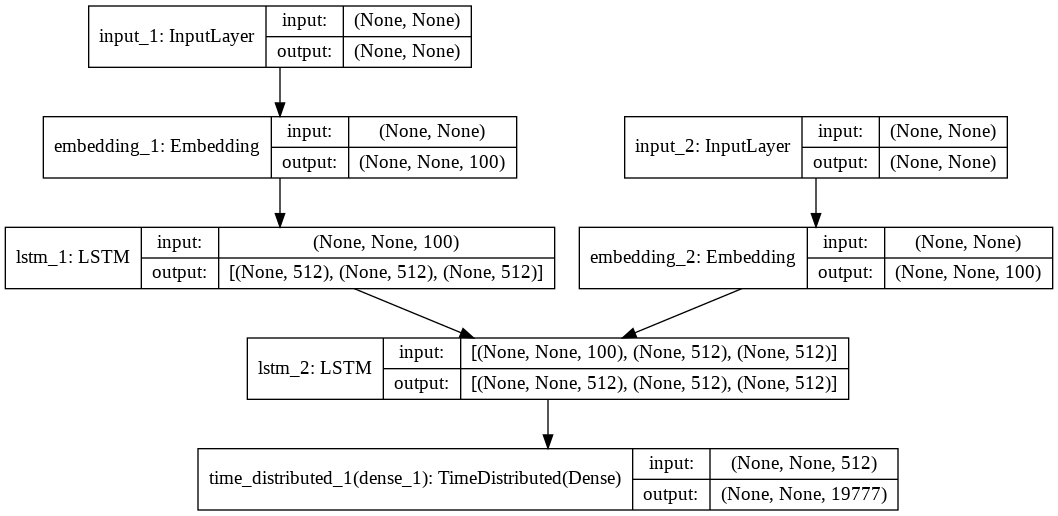

In [23]:
plot_model(model, show_layer_names=True,show_shapes=True)

In [0]:
# Encoder model for inference
model_encoder=Model(inputs=encoder_input,outputs=encoder_states)

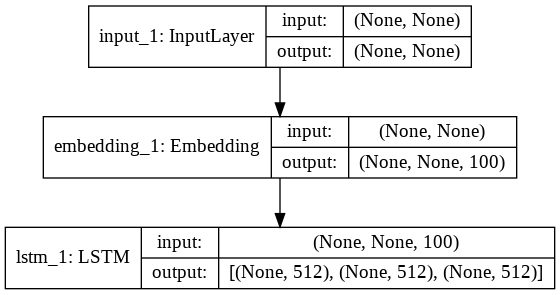

In [25]:
plot_model(model_encoder, show_layer_names=True,show_shapes=True)

In [0]:
# Decoder model for inference
decoder_state_h=Input(shape=(nunit,))
decoder_state_c=Input(shape=(nunit,))
decoder_state=[decoder_state_h,decoder_state_c]
decoder_emd2=decoder_emb(decoder_input)
decoder_lstm2,state_h,state_c,=decoder_lstm(decoder_emd2,initial_state=decoder_state)
decoder_out_state=[state_h,state_c]
decoder_output2=decoder_dense(decoder_lstm2)
model_decoder=Model(inputs=[decoder_input]+decoder_state,outputs=[decoder_output2]+decoder_out_state)

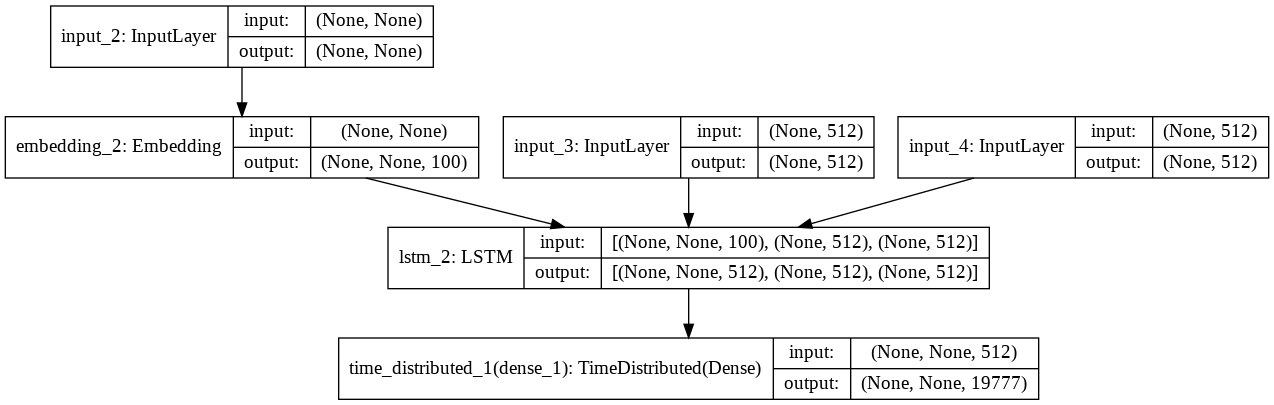

In [27]:
plot_model(model_decoder, show_layer_names=True,show_shapes=True)

In [28]:
model.compile(optimizer='RMSprop',loss=sparse_cross_entropy,target_tensors=decoder_target)

In [29]:
epoch=100
batches=256
mc=ModelCheckpoint("./"+version+".h5",monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=1)
tensorboard = TensorBoard(
  log_dir='log/'+version,
  histogram_freq=0,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(model)
es=EarlyStopping(patience=epoch//2,monitor='val_loss',verbose=1)
cb=[mc,tensorboard,es]

In [30]:
# Model input as eng to encoder and hindi to decoder
x=[encoder_input_data,decoder_input_data]
# model true output as shifted timestep hindi
y=decoder_output_data
model.fit(x,y,epochs=epoch,batch_size=batches,callbacks=cb,validation_split=0.2)



Train on 24833 samples, validate on 6209 samples
Epoch 1/100
24833/24833 [==============================] - 21s 838us/step - loss: 2.4099 - val_loss: 2.0271

Epoch 00001: val_loss improved from inf to 2.02710, saving model to ./v1.h5

Epoch 2/100
24833/24833 [==============================] - 19s 781us/step - loss: 1.8525 - val_loss: 1.8439

Epoch 00002: val_loss improved from 2.02710 to 1.84389, saving model to ./v1.h5
Epoch 3/100
24833/24833 [==============================] - 19s 778us/step - loss: 1.7345 - val_loss: 1.7792

Epoch 00003: val_loss improved from 1.84389 to 1.77922, saving model to ./v1.h5
Epoch 4/100
24833/24833 [==============================] - 19s 783us/step - loss: 1.6569 - val_loss: 1.7359

Epoch 00004: val_loss improved from 1.77922 to 1.73586, saving model to ./v1.h5
Epoch 5/100
24833/24833 [==============================] - 19s 779us/step - loss: 1.5933 - val_loss: 1.6869

Epoch 00005: val_loss improved from 1.73586 to 1.68691, saving model to ./v1.h5
Epoch 6

# Prediction

In [31]:
# hindi and english training token seq
testX=convert_to_seq(eng_tokenizer,x_test,eng_length)
testY=convert_to_seq(hindi_tokenizer,y_test,hindi_length)
testX.shape,testY.shape

((7761, 20), (7761, 32))

In [0]:
#load model
model.load_weights('./'+version+'.h5')
# load tokenizers
with open('./eng_tokenizer_'+version+'.pickle',"rb") as handle:
    eng_tokenizer=pickle.load(handle)

with open("./hindi_tokenizer_"+version+".pickle","rb") as handle:
    hindi_tokenizer=pickle.load(handle)

In [0]:
# extract word at the given index in tokenizer
def word_id(idx,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==idx:
      return word
  return None

In [0]:
# Convert prediction into words
def convert_out(model,tokenizer,test_input,tar_seq):
  # get the thought vector from encoder
  enc_states=model_encoder.predict(test_input.reshape(1,-1))
  flag=True
  output=''
  while flag:
    # predict the output and next state from decoder
    out_token,h,c=model_decoder.predict([tar_seq]+enc_states)
    # find the highest probable token
    out_index=np.argmax(out_token[0])
    # extract the word from tokenizer
    word=word_id(out_index,tokenizer)
    if word==None:
      break
    output+=' '+word
    #if the word is the end token or the length has reached max hindi length then break the loop
    if word=='eeeee' or len(output)>hindi_length:
      flag=False
    # assign new index to decoder
    tar_seq=np.zeros((1,1))
    tar_seq[0,0]=out_index
    #assign new state to decoder
    enc_states=[h,c]
  return output

In [0]:
# create the start token for decoder prediction
tar_seq=np.zeros((1,1))
tar_seq[0,0]=hindi_tokenizer.word_index['sssss']

In [36]:
# Predict for the dataset
english=[]
actual=[]
hindi=[]
for i in tqdm (range(len(testX))):
  sout=convert_out(model,hindi_tokenizer,testX[i],tar_seq)
  hindi.append(sout.replace('eeeee', ''))
  actual.append(y_test[i])
  english.append(x_test[i])

100%|██████████| 7761/7761 [04:13<00:00, 30.63it/s]


#  Output

In [0]:
df=pd.DataFrame({'English':english,'Actual':actual,'Hindi':hindi})

In [38]:
df.head()

,English,Actual,Hindi
0,into something else,SSSSS कुछ ओर में EEEEE,एक बार
1,into the machine,SSSSS कपड़े डाले EEEEE,जैसे की तरफ
2,somebody said the word revolution is a bad word,SSSSS किसी ने कहा क्रांति बुरा शब्द है EEEEE,उन्होंने कहा गया कि यह एक बहुत ही
3,we respond to stories more than data,SSSSS हम आंकड़ो की अपेक्षा कहनियों पर ज्यादा प...,हम इसे एक स्तर पर भी उपयोग करते हैं
4,with a small ruling class here in the united s...,SSSSS याहा पार अमेरिका में छोटेसे वर्ग के साथ ...,एक कागज के साथ एक छोटे छोटे से पहले


In [39]:
df.tail()

,English,Actual,Hindi
7756,that would be based in good part on tourism,SSSSS जो कि पर्यटन पर टिकी हो EEEEE,जो कि भविष्य में से अधिक हो रहा है
7757,it has to get very compelling before well pay ...,SSSSS इसको बहुत ही जयादा अकाट्य होना पड़ेगा इस...,यह सब कुछ भी नहीं होगा जो कि वो एक
7758,is tackling the problem of government,SSSSS सरकार के कार्यक्षमता कि समस्या का हल निक...,इस तरह की समस्या को
7759,through a tire from a jet plane,SSSSS एक जेट प्लेन के टायर से EEEEE,एक छोटी से शिक्षा के रूप में
7760,the key is they can never ever know it,SSSSS अंदर की बात ये है कि उन्हें कभी ये पता न...,एक बात है कि आप को देख सकते हैं


In [40]:
df.sample(50)

,English,Actual,Hindi
2192,or is it more likely that a reader of skeptic ...,SSSSS या इससे ज्यादा संभावना हैं कि “Skeptic” ...,या इस दुनिया को इस्तेमाल करने के
6211,its not just throwing them out at random,SSSSS आखिर इन्हें बिना किसी उद्द्देश्य के यूँ ...,यह नहीं है कि वे इसे करना चाहते हैं
1786,ill just show you some of the experiments,SSSSS मैं सिर्फ आपको कुछ प्रयोग दिखाऊंगा EEEEE,मैं आपको एक उदाहरण के लिए दिखाना
817,highways bridges things like that,SSSSS सडकें पुल और इस तरह की चीजें। EEEEE,जैसे कि कुछ भी कुछ हो
2639,and the cell on the right there,SSSSS और दायी तरफ की कोशिका EEEEE,और मानव के दशक में से
1620,and then as the ammonia reevaporates and combi...,SSSSS और फिर जैसे ही अमोनिया फिर से उड जाती है...,और फ़िर भी और फ़िर से ज्यादा ऊर्जा
7157,a friend of mine did that richard bollingbroke,SSSSS जिसे मेरे एक मित्र रिचर्ड बोलिंगब्रोकRic...,एक औरत ने एक बार लिखा था
1109,the ratio branko milanovic at the world bank ...,SSSSS अनुपातBranko Milanovic विश्व बैंक में पर...,के दशक में हमारे पास करोड डॉलर के
2663,and its a copyright violation,SSSSS और ये कॉपीराइट का हनन है। EEEEE,और यह एक और बड़ा रूप है
2096,and my experience in the private sector,SSSSS और निजी क्षेत्र के अनुभव को इस क्षेत्र म...,और मेरे पिता की एक मुलाकात थी


#Visualisation

In [0]:
%reload_ext tensorboard
#%tensorboard --inspect --logdir ./log/v1/

In [47]:
%tensorboard --logdir ./log/v1/

Reusing TensorBoard on port 6006 (pid 995), started 0:51:52 ago. (Use '!kill 995' to kill it.)

# BLEU Score

In [0]:
from nltk.translate.bleu_score import corpus_bleu
def evaluate_model(actual,predicted):
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [46]:
evaluate_model(df['Actual'].values,df['Hindi'].values)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.365668
BLEU-2: 0.604705
BLEU-3: 0.739479
BLEU-4: 0.777628


# REFERENCES:
https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/
https://github.com/prateekjoshi565/machine_translation/blob/master/german_to_english.ipynb
https://github.com/tensorflow/tensorflow/issues/17150
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb
https://www.tensorflow.org/tutorials/text/nmt_with_attention
https://gist.github.com/rmdort/acb30d2552b146712eda71de956b8a00
https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html
https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
https://github.com/thushv89/attention_keras/blob/master/examples/nmt_bidirectional/train.py
https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/
https://towardsdatascience.com/word-level-english-to-marathi-neural-machine-translation-using-seq2seq-encoder-decoder-lstm-model-1a913f2dc4a7
https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39
https://towardsdatascience.com/neural-machine-translation-using-seq2seq-with-keras-c23540453c74
https://github.com/pradeepsinngh/Neural-Machine-Translation/blob/master/machine_translation.ipynb
https://machinelearningmastery.com/configure-encoder-decoder-model-neural-machine-translation/
https://machinetalk.org/2019/03/29/neural-machine-translation-with-attention-mechanism/
https://github.com/ChunML/NLP/blob/master/machine_translation/train_luong_tf2.py
https://www.kaggle.com/aiswaryaramachandran/hindienglish-corpora
https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
https://github.com/datalogue/keras-attention/tree/master/models
https://machinelearningmastery.com/calculate-bleu-score-for-text-python/